In [1]:
import json
import warnings
import copy

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings(action='ignore')


def read_jsonl_file(path):
    json_lines = []
    with open(path, 'r') as f:
        for line in f:
            json_lines.append(json.loads(line.strip()))
    return json_lines



def extract_importances():
    
    
    X = []
    y = []
    for match in matches:

        list_att_home = []
        list_att_away = []

        for i in match['home_players']:
            
            # assign hometeam goalkeeper's attributes first.
            if merged_data[str(i)]['is_goalkeeper']==1:
                key_home_keeper = i
                
                for k, j in merged_data[str(i)]['premier_stats'].items():
                    list_att_home.append(j)

                for k, j in merged_data[str(i)]['fm_stats'].items():
                    list_att_home.append(j)
        
        for i in match['home_players']:
            
            # assign hometeam field players' attributes.
            if i != key_home_keeper:
                
                for k, j in merged_data[str(i)]['premier_stats'].items():
                    list_att_home.append(j)

                for k, j in merged_data[str(i)]['fm_stats'].items():
                    list_att_home.append(j)

                    
                    
        for i in match['away_players']:
            
            # assign awayteam goalkeeper's attributes first.
            if merged_data[str(i)]['is_goalkeeper']==1:
                key_away_keeper = i
                
                for k, j in merged_data[str(i)]['premier_stats'].items():
                    list_att_away.append(j)

                for k, j in merged_data[str(i)]['fm_stats'].items():
                    list_att_away.append(j)
        
        for i in match['away_players']:
            
            # assign awayteam field players' attributes.
            if i != key_away_keeper:
                
                for k, j in merged_data[str(i)]['premier_stats'].items():
                    list_att_away.append(j)

                for k, j in merged_data[str(i)]['fm_stats'].items():
                    list_att_away.append(j)

                
        x = np.array(list_att_away + list_att_home)    
        X.append(x)
        y.append(int(match['match_result']))

        
    X = np.asarray(X)
    y = np.asarray(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    clf = RandomForestClassifier(random_state = 42, class_weight='balanced')
    
    feature_names = [f'feature {i}' for i in range(X.shape[1])]
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    clf_importances = pd.Series(importances, index=feature_names)

    return clf_importances

In [2]:
matches = read_jsonl_file('/Users/jooyong/github_locals/aml_5525/aml_5525/dataset/processed/team_ids_player_ids.json')

with open('/Users/jooyong/github_locals/aml_5525/aml_5525/dataset/merged_data/final_players(normalized_official).json') as f:
    merged_data = json.load(f)

In [3]:
clf_importances = extract_importances()

In [4]:
importances = list(clf_importances)

In [5]:
dict_importances = {}

home_keeper_importances = importances[:66]
home_field_importances = importances[66:706]
away_keeper_importances = importances[706:772]
away_field_importances = importances[772:]

dict_importances['home_keeper'] = home_keeper_importances

for i in range(10):
    dict_importances[f'home_field_{i+1}'] = home_field_importances[64*(i):64*(i+1)]

dict_importances['away_keeper'] = away_keeper_importances    

for i in range(10):
    dict_importances[f'away_field_{i+1}'] = away_field_importances[64*(i):64*(i+1)]

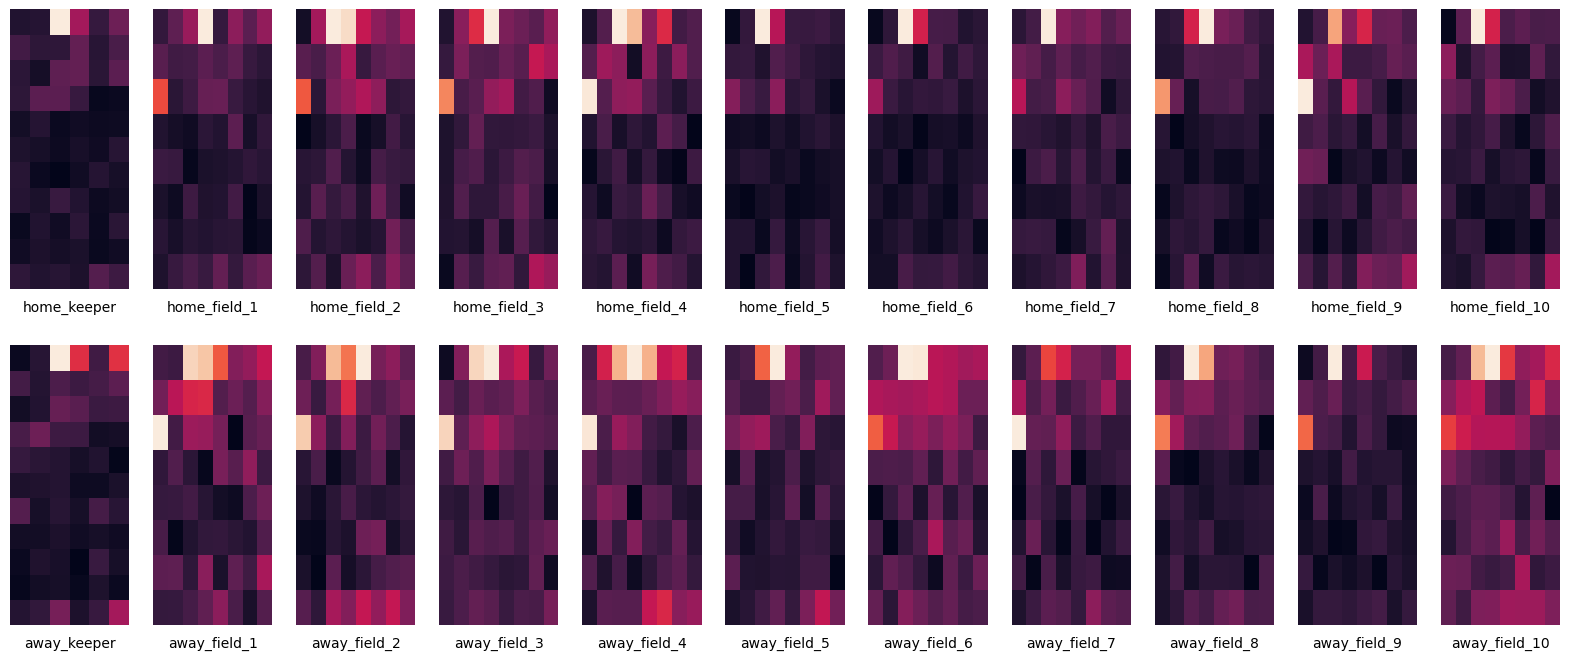

In [6]:
plt.figure(figsize=(20,8))

for i in range(len(dict_importances)):
    
    if list(dict_importances.keys())[i] == 'home_keeper' or list(dict_importances.keys())[i] == 'away_keeper':
        temp = np.reshape(dict_importances[list(dict_importances.keys())[i]], (11,6))
        temp = pd.DataFrame(temp)
    
    else:
        temp = np.reshape(dict_importances[list(dict_importances.keys())[i]], (8,8))
        temp = pd.DataFrame(temp)       
    
    plt.subplot(2, 11, i+1)
    sns.heatmap(temp, cbar=False, xticklabels=False, yticklabels=False)
    plt.xlabel(list(dict_importances.keys())[i])

In [7]:
fields = home_field_importances + away_field_importances
fields = np.reshape(fields, (20, 64))
fields = pd.DataFrame(fields)

list_ave_imp_fields = []
for i in range(64):
    list_ave_imp_fields.append(fields[i].mean())
    
list_ave_imp_fields_copy = copy.deepcopy(list_ave_imp_fields)

list_ave_imp_fields.sort(reverse=True)
top_20 = list_ave_imp_fields[:20]

index_top_20 = []
for i in top_20:
    index_top_20.append(list_ave_imp_fields_copy.index(i))
    
list_atts_field = []
for i in merged_data['2008']['premier_stats'].keys():
    list_atts_field.append(i)
for i in merged_data['2008']['fm_stats'].keys():
    list_atts_field.append(i)
    
selected_field_att = []
for i in index_top_20:
    selected_field_att.append(list_atts_field[i])
  
print('top_20 important attributes of field players')
print(selected_field_att)

top_20 important attributes of field players
['losses', 'wins', 'attempts_conceded_ibox', 'draws', 'mins_played', 'attempts_conceded_obox', 'total_final_third_passes', 'accurate_fwd_zone_pass', 'total_pass', 'accurate_pass', 'successful_final_third_passes', 'duel_won', 'poss_lost_all', 'touches', 'Sell value', 'duel_lost', 'ability', 'appearances', 'total_fwd_zone_pass', 'potential']


In [8]:
keepers = home_keeper_importances + away_keeper_importances
keepers = np.reshape(keepers, (2, 66))
keepers = pd.DataFrame(keepers)

list_ave_imp_keepers = []
for i in range(66):
    list_ave_imp_keepers.append(keepers[i].mean())
    
list_ave_imp_keepers_copy = copy.deepcopy(list_ave_imp_keepers)

list_ave_imp_keepers.sort(reverse=True)
top_20 = list_ave_imp_keepers[:20]

index_top_20 = []
for i in top_20:
    index_top_20.append(list_ave_imp_keepers_copy.index(i))
    
list_atts_keeper = []
for i in merged_data['54392']['premier_stats'].keys():
    list_atts_keeper.append(i)
for i in merged_data['54392']['fm_stats'].keys():
    list_atts_keeper.append(i)
    
selected_keeper_att = []
for i in index_top_20:
    selected_keeper_att.append(list_atts_keeper[i])
    
print('top_20 important attributes of goalkeepers')
print(selected_keeper_att)

top_20 important attributes of goalkeepers
['losses', 'wins', 'attempts_conceded_ibox', 'potential', 'saves', 'poss_lost_all', 'poss_lost_ctrl', 'total_long_balls', 'long_pass_own_to_opp', 'accurate_back_zone_pass', 'accurate_long_balls', 'Sell value', 'ability', 'touches', 'goal_kicks', 'mins_played', 'Anticipation', 'keeper_throws', 'ball_recovery', 'total_fwd_zone_pass']
